### Assignment 4

#### Submit your assignment as .ipynb

#### Exercise 1.

Write a function

In [1]:
def diff(f, x0, h):
    p1=(f(x0+h)-f(x0-h))/(2*h)
    return p1

def MyFirstDeriv(f, x0, h):
    p1 = diff(f, x0, h)
    p2 = diff(f, x0, h/2)
    p3 = (4*p2 - p1)/3
    return p3

to compute the derivative $f'(x_0)$ of the function $f$ of an unknown form, using Richardson extrapolation with the central difference g(h) and the step sizes $h$ and $\displaystyle \frac{h}{2}$.
Conduct some simple test cases for the function.


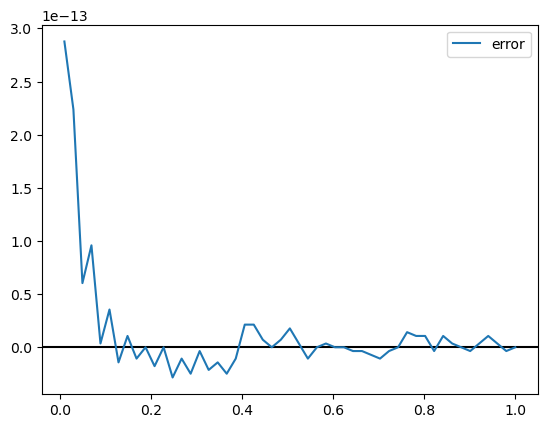

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from numpy.polynomial import Polynomial


def error(f, x_i, hs):
    f_prime = f.deriv(1)
    Y_actual = f_prime(x_i) 

    diff_error = []

    for h in hs:
        diff_error.append(Y_actual - MyFirstDeriv(f, x_i, h))

    #print(pd.DataFrame({"h": hs, "Diff": diff_error}))
    
    return diff_error

# Test case: y = 2 + 5 x + 3.5 x^2

p = Polynomial([2.0, 5.0, 3.5], domain=[-1, 1])

fig, ax = plt.subplots()
ax.axhline(y=0, color='k')
hs = np.linspace(1, 0.01, num=51)
errorvalue = error(p, 2.0, hs)
ax.plot(hs, errorvalue, label='error')

ax.legend()

#### Exercise 2.

This exercise considers a smoothed version of binomial tree pricer for American put options.
Unlike the standard binomial tree pricer that evaluates the payoff function at the final time step,
we can skip the final time step payoff evaluation, but start from the second last time step by applying Black-Scholes analytic formula for European put option to calculate the continuation value.
This is because the American early exercise feature vanishes at the last time step. So at the second time step, if the option holder decides not to exercise, he/she has left with a European option with time to expiry equal to the time interval $\Delta t$.
Note that you still need to update the node's value using maximum of continuation value and exercise value at the second last step.
Compared with the standard tree pricer where the final time slice is a non-differentiable function at the strike,
the smooth Black-Scholes analytic formula would help stablizing the risk sensitivities.

Implement the function

In [25]:
from enum import Enum
import math

class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'
    BinaryCall = 'BinaryCall'
    BinaryPut = 'BinaryPut'


def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def bsPrice(S, r, vol, T, strike, payoffType):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    elif payoffType == PayoffType.BinaryCall:
        return math.exp(-r * T) * cnorm(d1)
    elif payoffType == PayoffType.BinaryPut:
        return math.exp(-r * T) * (1-cnorm(-d1))
    else:
        raise Exception("not supported payoff type", payoffType)

class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

In [26]:
def amerPutSmooth(S, T, v, r, n, K):
#    S: spot price at time 0
#    T: time to maturity (in years)
#    v: the volatility
#    r: risk-free rate
#    n: the number of time steps
#    K: the strike of the american call option

    t = T/n
    b = math.exp(v * v * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    S1 = [S * u**(n-1-i-i) for i in range(n)]
    
    trade = AmericanOption(T, K, PayoffType.Put)
    payoff = [trade.payoff(S1[i]) for i in range(n)] 
    contin_value = [bsPrice(S1[i], r, v, t, K, PayoffType.Put) for i in range(n)] # Continuation value
    vs = [max(payoff[i], contin_value[i]) for i in range(n)]
    
    # iterate backward
    for i in range(n-2, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            nodeS = S * u**(i-j-j)
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
            vs[j] = trade.valueAtNode(t*i, nodeS, continuation)
    return vs[0]

to explore this method with CRR binomial model. Conduct two test cases:

1) Plot the option's delta (using MyFirstDeriv implemented in Exercise 1 with step size $h$ set to 1 dollar)
for $n$ from 5 to 200, for both the smoothed version of the pricer and the standard American put option pricer given in the example code,
with $S = 100, K = 108, T = 1, v = 15\%, r = 3\%$.

2) Plot the option's delta
for $S$ from 75 to 150, for both the smoothed version of the pricer and the standard American put option pricer given in the example code,
with $n = 200, K = 108, T = 1, v = 15\%, r = 3\%$.

In [27]:
def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, v, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

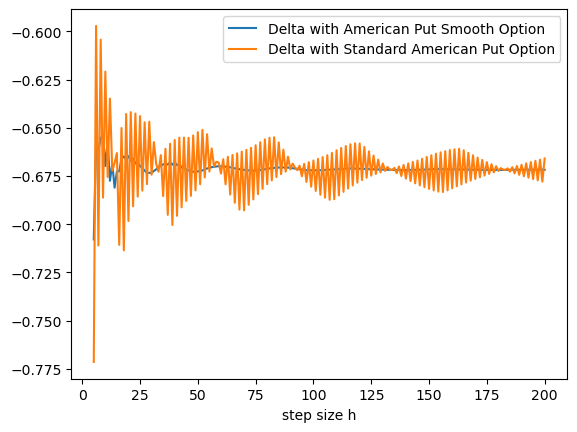

In [29]:
S0, K = 100, 108
T = 1
v, r, h = 0.15, 0.03, 1

trade = AmericanOption(T, K, PayoffType.Put)

delta_amerSmooth = [MyFirstDeriv(lambda S:amerPutSmooth(S, T, v, r, n, K), S0, h) for n in range(5,201)]
delta_StandAmer = [MyFirstDeriv(lambda S:binomialPricer(S, r, v, trade, n, crrCalib), S0, h) for n in range(5,201)]
plt.plot(range(5,201), delta_amerSmooth, label = 'Delta with American Put Smooth Option')
plt.plot(range(5,201), delta_StandAmer, label = 'Delta with Standard American Put Option')
plt.xlabel('step size h')
plt.legend()
plt.show()

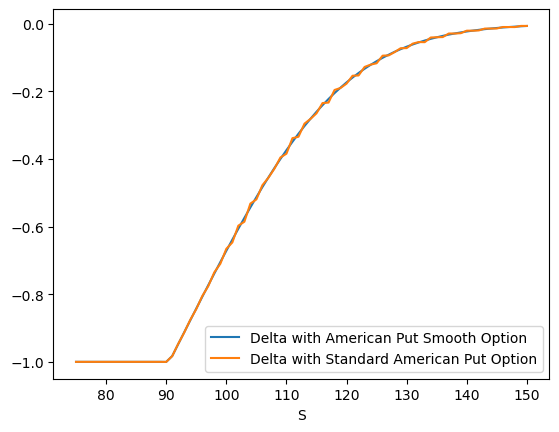

In [30]:
delta_amerSmooth = [MyFirstDeriv(lambda S:amerPutSmooth(S, T, v, r, 200, K), S0, h) for S0 in range(75,151)]
delta_StandAmer = [MyFirstDeriv(lambda S:binomialPricer(S, r, v, trade, 200, crrCalib), S0, h) for S0 in range(75,151)]
plt.plot(range(75,151), delta_amerSmooth, label = 'Delta with American Put Smooth Option')
plt.plot(range(75,151), delta_StandAmer, label = 'Delta with Standard American Put Option')
plt.xlabel('S')
plt.legend()
plt.show()

#### Exercise 3.

A double no touch option has two barrier levels: upBarrier and downBarrier.
When the stock price touches one of the barriers the option is terminated.
If the barriers are not touched until the option expiry date, the option pays 1 dollar.

Implement a double no touch option pricer in PDE with Crank-Nicolson scheme.

In [32]:
from enum import Enum
class BoundaryType(Enum):
    Dirichlet = 0
    Neumann = 1
    Linear = 2

def dntPDEPricer(S, T, r, q, v, upBarrier, downBarrier, nT, nS):
    # S: the spot price
    # T: time to expiry
    # r: risk free interest rate
    # q: dividend yield
    # v: volatility
    # upBarrier: the up barrier
    # downBarrier: the down barrier
    # nT: number of time intervals (equally spaced)
    # nS: number of S grid points

    # PDE grid
    mu = r - q
    srange = 5 * v * math.sqrt(T)
    maxS = S0 * math.exp((mu - v * v * 0.5)*T + srange)
    minS = S0 * math.exp((mu - v * v * 0.5)*T - srange)
    dt = T / (nT-1)
    ds = (maxS - minS) / (nS-1)
    # Spot value grid
    sGrid = np.array([minS + i*ds for i in range(nS)])

    # Lambda function for returning dntoption payoff
    dntpayoff = lambda x: 0 if x >= upBarrier or x <= downBarrier else 1
    
    ps = np.array([dntpayoff(s) for s in sGrid])
    # set up the matrix, for BS the matrix does not change
    # for LV we need to update it for each iteration
    a, b = mu/2.0/ds, v * v / ds / ds
    M = np.zeros((nS, nS))
    D = np.zeros((nS, nS))
    for i in range (1, nS-1):
        M[i, i-1] = a*sGrid[i] - b*sGrid[i]*sGrid[i]/2.0
        M[i, i] = r + b * sGrid[i] * sGrid[i]
        M[i, i+1] = -a * sGrid[i] - b*sGrid[i]*sGrid[i]/2.0
        D[i,i] = 1.0
    # the first row and last row depends on the boundary condition
        M[0,0], M[nS-1, nS-1] = 1.0, 1.0

    w = 0.5
    rhsM = (D - dt * M) * w + (1-w) * np.identity(nS)
    lhsM = w * np.identity(nS) + (D + dt * M) * (1-w)
    inv = np.linalg.inv(lhsM)
    # backward induction

    for j in range(1, nT):
        ps = rhsM.dot(ps)
        ps[0] = dt*math.exp(-r*j*dt) * dntpayoff(sGrid[0]) # discounted payoff
        ps[nS-1] = dt*math.exp(-r*j*dt) * dntpayoff(sGrid[nS-1])
        ps = inv.dot(ps)
    # linear interpolate the price at S0
    return np.interp(S0, sGrid, ps)

When the spot is beyond the up and down barriers the option worths 0,
so we can set the boundaries of the S grid at exactly the up and down barrier levels, and use Dirichlet boundary condition.

For $S_0 = 100, T = 1, \sigma = 15\%, r = 5\%, q = 3\%, nT = 100, nS = 100$,
plot the double no touch price as a function of x which determines the barrier levels: upBarrier = 100+x, downBarrier = 100-x. What should be the price converges to when x is large enough?
Verify that is the case in the plot.


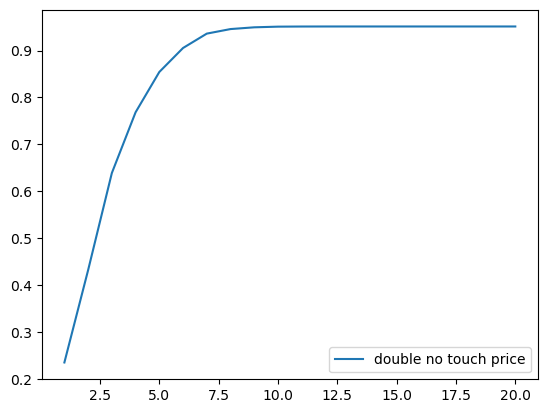

In [33]:
S0, T, v = 100, 1, 0.15**2
r, q = 0.05, 0.03
nT, nS = 100, 100

prices = []
for i in range(1,21):
    dntprice = dntPDEPricer(S0, T, r, q, v, 100 + i, 100 - i, nT, nS)
    prices.append(dntprice)
plt.plot(range(1,21), prices, label = 'double no touch price')
plt.legend()
plt.show()

#### Exercise 4.

a) Write a ODE solver using Euler explicit method:

In [22]:
def eulerODEExplicit(f, x0, y0, n, x):
    h = (x - x0) / n
    y = [y0] * (n+1)
    x = [x0] * (n+1)
    for i in range(1,n+1):
        x[i] = x0 + i*h
        y[i] = y[i-1] + h * f(x[i-1], y[i-1])
    return y[n]

The function returns the value $y$ at the given $x$ by solveing the ODE:
\begin{align}
y' = f(x,y)
\end{align}
with initial value $(x_0, y_0)$ and number of time steps $n$.

b) Write a ODE solver using Euler implicit method for the ODE:
\begin{align}
y' = -3y
\end{align}

In [23]:
def eulerODEImplicit(x0, y0, n, x):
    h = (x - x0) / n
    y = [y0] * (n+1)
    x = [x0] * (n+1)
    for i in range(1,n+1):
        x[i] = x0 + i*h
        y[i] = (1/(1+h*3)) * y[i-1] 
    return y[n]

c) And Crank-Nicholson:

In [24]:
def eulerODECrankN(x0, y0, n, x):
    h = (x - x0) / n
    y = [y0] * (n+1)
    x = [x0] * (n+1)
    for i in range(1,n+1):
        x[i] = x0 + i*h
        y[i] = ((2-h*3)/(2+h*3)) * y[i-1] 
    return y[n]

d) Test the three solvers using initial point x0 = 0, y0 = 1, solve $y$ for $x$ from $[-15, -14, \ldots, 15]$ with a reasonable choice of $n$.
Print out the errors of the solver for each $x$ (note that the error is not necessarily small for all $x$ and all methods, explain the source of errors for the cases the error is obviously not small).

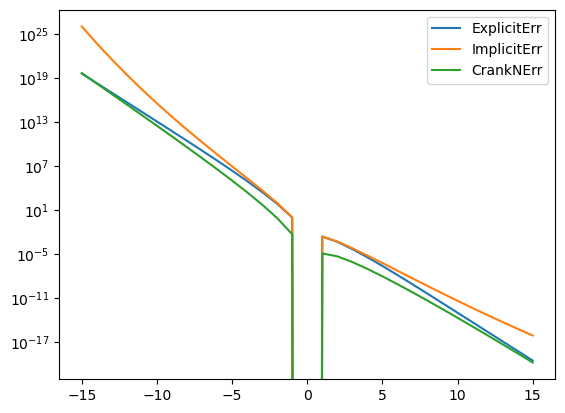

In [34]:
x0, y0, n = 0, 1, 100

# lamda function for the equation we are trying to solve
f = lambda x, y: -3*y

ExplicitErr = [abs(eulerODEExplicit(f, x0, y0, n, x) - math.exp(-3 * x)) for x in np.arange(-15,16,1)]
ImplicitErr = [abs(eulerODEImplicit(x0, y0, n, x) - math.exp(-3 * x)) for x in np.arange(-15,16,1)]
CrankNErr = [abs(eulerODECrankN(x0, y0, n, x) - math.exp(-3 * x)) for x in np.arange(-15,16,1)]
plt.plot(np.arange(-15,16,1), ExplicitErr, label = 'ExplicitErr')
plt.plot(np.arange(-15,16,1), ImplicitErr, label = 'ImplicitErr')
plt.plot(np.arange(-15,16,1), CrankNErr, label = 'CrankNErr')
plt.yscale('log')
plt.legend()
plt.show()